In [1]:
import pandas as pd
import numpy as np
import talib
import pandas_profiling as pdp
import sweetviz as sv

import os
import sys
from pygam import s, LinearGAM
import category_encoders as ce
from typing import List, Dict

import matplotlib.pyplot as plt
import seaborn as sns

import ptitprince
from matplotlib_venn import venn2
plt.rcParams['font.family'] = 'Hiragino Maru Gothic Pro'

from common_module.utils.plot import (
    plot_venn,
    plot_histogram,
    plot_raincloud,
    plot_heatmap,
    plot_histgram_for_valid,
    plot_lineargam,
    plot_feature_importance_for_valid
)
from common_module.utils.summarize import (
    get_pandas_profiling,
    get_sweetviz_report
)
from common_module.utils.preprocessor import (
    OrdinalEncodingBlock,
    CountEncodingBlock,
    GroupingBlock
)
from common_module.utils.format_df import format_df

# from atma_coffee.modules.config_manager import ConfigManager

sys.path.append("../")
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 100)

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
# read
df_train_origin = pd.read_csv("../input/train_data.csv", encoding="utf-8-sig")
df_company_list_origin = pd.read_csv("../input/company_list.csv", encoding="utf-8-sig")
df_sub_template = pd.read_csv("../input/submission_template.csv", encoding="utf-8-sig")

# shape
display(df_train_origin.shape)
display(df_company_list_origin.shape)
display(df_sub_template.shape)

(420, 3279)

(7007, 6)

(3278, 2)

In [3]:
print("■train_data")
display(df_train_origin.shape)
display(df_train_origin.head(4))

print("■company_list")
display(df_company_list_origin.shape)
display(df_company_list_origin.head(1))

print("■submission_template")
display(df_sub_template.shape)
display(df_sub_template.head(1))

■train_data


(420, 3279)

,Date,VGSH,JEF,IVZ,KTCC,FBZ,PLOW,JBK,IAC,IVR,VSH,VCV,OKE,ROK,FTAG,BRKR,GSK,JPS,SRPT,VMI,IMKTA,BDR,JAKK,MVC,AMSF,APTO,CNX,XOMA,LBY,BIOL,PAAS,KOF,LAC,EML,IVC,TILE,IEF,CSV,QADA,TBNK,HOG,WIW,SVBI,PKOH,CREG,LOGM,ERII,PEBO,PEER,ORA,RIO,BPOPM,PDLI,RYN,UNAM,PFD,CALX,SNSS,TCF,MTRX,AVGO,MSM,REV,HSY,PEP,REED,HPQ,BKTI,MPB,AAON,PSO,CIG,NAC,OPNT,RE,SES,RTN,WST,HIHO,FLC,EFT,DCI,IIF,BANC,CRS,GAIN,UHT,TMO,MFNC,TEX,LTBR,QGEN,EVV,BBY,MRKR,CSQ,KBAL,QRHC,ANIP,FMBH,...,CONN,EGO,CY,ICLN,NNVC,AIZ,XAN,ALIM,PFL,WIA,TRST,EXD,HNW,SBLK,AUBN,GSIT,ISSC,ESGR,CAMT,CKH,CLS,ZTR,SIRI,PFM,ANTE,PZC,DSLV,WDC,PRPH,RS,BOTJ,CE,HAIN,QCLN,ATR,WSM,LNG,VTWO,FRC,FUL,ICFI,CIZN,UFI,MXIM,MRLN,GTT,CR,SXT,NBTB,ADI,EVK,WSBC,ACER,CHN,CORT,FLIC,ADTN,PFLT,AVID,TSEM,KRO,MORN,BHV,MMU,SGRP,PBA,GF,OSPN,J,AMKR,CPHI,TRT,OPRX,DXYN,GFED,FRAF,HWCC,WYND,CHMG,EVC,NNA,IOR,ATLC,STWD,TTM,NOC,EQS,MKC,MXL,NEV,ASFI,JTA,MNR,TFSL,GTN,TYG,VIRC,BIS,WOOD,MASI
0,2011/11/13,55.942184,17.649006,13.770864,4.77,13.818835,10.198389,12.440549,38.484608,4.836254,8.575465,7.877108,23.100210,59.334507,84.253273,11.731660,28.273636,4.168243,4.86,75.028809,12.110400,1.13,18.456266,7.713052,15.194721,2.88,29.963728,30.400000,10.973586,14.384466,20.405405,73.412354,1.75,16.415005,19.071070,10.358725,88.829475,5.339281,10.804994,15.035470,29.228592,9.278417,2.594832,17.814543,14.5,38.607750,2.50,9.508274,22.400000,17.544151,34.077663,9.051845,4.036423,21.052782,10.179731,7.213885,8.41,7.50,14.216700,9.68,24.646343,50.906437,14.46,46.303482,49.788853,1.39,8.927394,0.877275,6.139855,8.682248,12.204165,3.919564,8.690806,0.42,73.116982,98.559998,35.922192,17.122187,1.637933,9.453785,8.308208,28.895016,9.979239,8.690458,45.424389,3.396492,23.906984,44.114647,3.987525,13.897991,187.800003,13.728254,7.737930,21.358797,288.0,4.088526,3.683195,18.000000,84.599998,14.962660,...,9.95,83.039902,13.923010,7.072347,55.299999,31.703871,11.661029,1.29,4.546225,9.558780,3.620234,7.187960,8.973720,84.834564,14.881336,4.86,3.010909,96.360001,1.812006,58.838348,8.25,4.215335,1.700923,11.964488,14.300000,5.702804,43.799999,20.713301,0.762946,36.546154,4.475960,35.595501,17.670000,9.581954,42.146973,29.780903,11.70,51.195068,22.606068,20.090033,24.530502,11.557922,7.89,19.594046,8.667803,1.36,38.136402,30.210152,15.731730,28.358801,1.37,15.125630,373.333344,10.369422,3.39,9.227671,27.211815,5.037442,7.10,10.65,12.701912,53.690952,13.001904,8.411827,1.22,16.457903,6.239215,8.04,39.470684,4.63,0.88,2.40,3.06,2.93,4.992733,10.988591,9.748321,10.293147,17.453051,1.078169,33.496590,1.92,3.16,6.810544,15.831424,47.542465,2.21,40.948685,4.96,8.450615,3.721562,4.747546,5.567790,7.262252,1.80,20.079035,1.504111,826.767029,30.918266,18.430309
1,2011/11/20,55.978844,16.270664,12.719761,4.94,12.744166,10.035272,12.065370,36.252533,4.658076,7.657301,7.939425,22.540537,55.720310,78.528595,11.262002,27.104542,4.072667,4.08,69.938858,11.282884,1.14,17.461733,6.991731,14.490328,2.52,27.630514,30.799999,10.061356,12.466537,20.022963,68.245247,1.65,16.306412,18.346851,8.876307,89.084717,5.274280,9.564995,14.278780,27.989960,9.314977,2.662356,15.294662,12.5,34.829571,2.27,7.991528,22.400000,15.904687,30.586075,9.023554,4.063376,19.843987,10.206950,7.154890,7.18,6.90,12.750013,8.53,23.474276,48.047035,13.74,45.746265,48.697853,1.40,8.098125,0.919861,6.164315,7.810735,11.651024,3.674882,8.618720,0.40,69.981857,89.599998,35.203728,16.185606,1.494254,9.253301,8.163390,27.018999,9.378841,7.772503,41.059013,3.186542,22.347122,42.692211,4.068903,11.817956,160.800003,13.438292,7.711720,20.230078,264.0,3.903125,3.333358,19.600000,79.919998,15.667272,...,10.10,79.030418,12.645804,6.734447,49.700001,30.477777,11.191008,1.19,4.488735,9.543862,3.398002,7.272264,8.764602,84.780708,14.881336,4.69,2.892424,91.690002,1.634359,56.146488,7.54,4.132953,1.672256,11.491554,15.050000,5.714909,47.240002,19.886042,0.835607,35.020405,3.670286,35.281651,17.620001,8.790443,40.813152,28.370873,10.21,47.593803,21.723381,18.736162,23.587021,11.517131,7.39,18.258261,7.567554,1.30,36.288921,

■company_list


(7007, 6)

,Symbol,Name,IPOyear,Sector,Industry,List
0,XXII,"22nd Century Group, Inc",NaN,Consumer Non-Durables,Farming/Seeds/Milling,AMEX


■submission_template


(3278, 2)

,id,y
0,VGSH,NaN


## EDA

### company list

- Symbolが重複している場合がある
    - Listが異なっている
- nullがある列がある
    - IPOyear
    - Sector
    - Industry

In [4]:
# # summary
# get_pandas_profiling(
#     df=df_company_list_origin,
#     output_path="/Users/saitouteruaki/Desktop/data_science/probspace_usstock/output",
#     output_name="profile"
# )

In [5]:
# Symbolの重複 -> 重複上場
display(df_company_list_origin[df_company_list_origin["Symbol"] == "NCLH"])

# nullのある列
display(df_company_list_origin.info())

,Symbol,Name,IPOyear,Sector,Industry,List
2684,NCLH,Norwegian Cruise Line Holdings Ltd.,NaN,Consumer Services,Marine Transportation,NASDAQ
5890,NCLH,Norwegian Cruise Line Holdings Ltd.,NaN,Consumer Services,Marine Transportation,NYSE


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7007 entries, 0 to 7006
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Symbol    7007 non-null   object 
 1   Name      7007 non-null   object 
 2   IPOyear   3211 non-null   float64
 3   Sector    5347 non-null   object 
 4   Industry  5347 non-null   object 
 5   List      7007 non-null   object 
dtypes: float64(1), object(5)
memory usage: 328.6+ KB


None

In [6]:
duplicate_companies = ["NCLH", "MSG", "PGTI", "CDOR", "SAVE"]

def create_company_features(
    input: pd.DataFrame,
    duplicate_companies: List[str]
) -> pd.DataFrame:
    # baseのdfを作成
    df_base = input[["Symbol", "IPOyear", "Sector"]].drop_duplicates()
    # listで重複上場している会社があるためリストを修正
    df_list = modify_list_column(input, duplicate_companies)
    df_output = pd.merge(df_base, df_list, how="left", on="Symbol")
    return df_output


def modify_list_column(
    input: pd.DataFrame,
    duplicate_companies: List[str]
) -> pd.DataFrame:
    df_list = input[["Symbol", "List"]].copy()
    df_list.loc[df_list["Symbol"].isin(duplicate_companies), "List"] = "NASDAQ_NYSE"
    df_output = df_list.drop_duplicates()
    return df_output

df_comp = create_company_features(input=df_company_list_origin, duplicate_companies=duplicate_companies)
display(df_comp[df_comp["Symbol"].isin(duplicate_companies)])

,Symbol,IPOyear,Sector,List
73,CDOR,NaN,Consumer Services,NASDAQ_NYSE
2689,NCLH,NaN,Consumer Services,NASDAQ_NYSE
2897,PGTI,2006.0,Capital Goods,NASDAQ_NYSE
3332,SAVE,NaN,Transportation,NASDAQ_NYSE
3499,MSG,2015.0,Consumer Services,NASDAQ_NYSE


<AxesSubplot:>

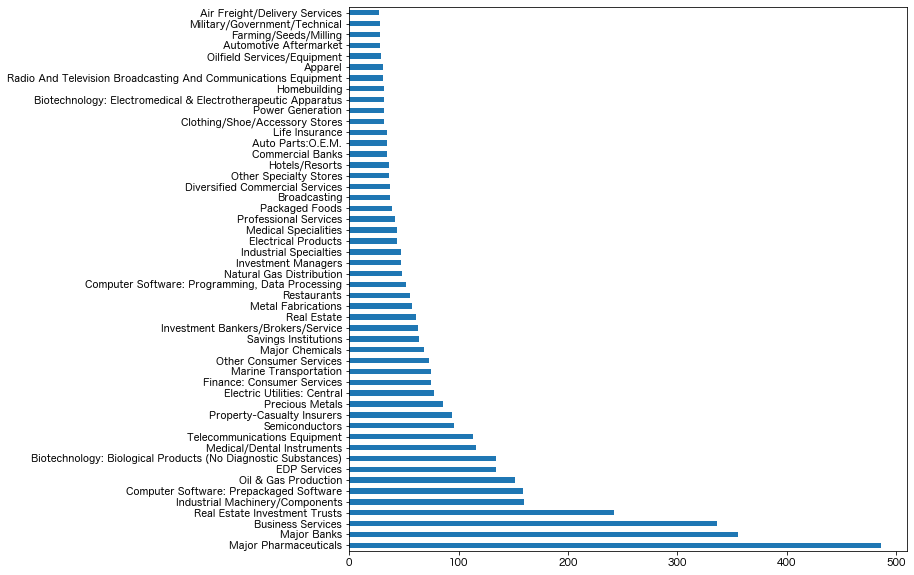

In [7]:
# Sectorにより大きい粒度の情報があるため一旦不要
df_company_list_origin["Industry"].value_counts().head(50).plot.barh(figsize=(10, 10))

## 目的変数の設定

- 収益率(=log(当日) - log(前日))が良さそう
    - 計算方法
        - 1. 対数化（np.log1p）※戻すのはnp.expm1
        - 2. 前日との差分（diff）
    - 理由
        - トレンドを削除できる
        - 桁数をある程度抑制できる

In [8]:
def melt_dataframe(input: pd.DataFrame) -> pd.DataFrame:
    """横持ちを縦持ちに変換する関数

    Args:
        input (pd.DataFrame): _description_

    Returns:
        pd.DataFrame: _description_
    """
    symbol_list = input.columns[1:]  # 0はDate
    df = pd.melt(
        input,
        id_vars="Date",
        value_vars=symbol_list,
        value_name="stock_price"
    )
    df = df.rename(columns={"variable": "Symbol"})  # defaultでvariableになるため
    df = df[df["Date"].notnull()]  # Dateがnullで他も全てnullの行があるため
    return df


def create_base_dataframe(
    input: pd.DataFrame,
    df_company: pd.DataFrame
) -> pd.DataFrame:
    """ラグ特徴量を作成するために必要な情報を追加する関数

    Args:
        input (pd.DataFrame): _description_
        df_company (pd.DataFrame): _description_

    Returns:
        pd.DataFrame: _description_
    """
    df = input[["Date", "Symbol", "stock_price"]].copy()
    df = pd.merge(df, df_company[["Symbol", "List"]], how="left", on="Symbol")
    output_cols = ["Date", "Symbol", "List", "stock_price"]
    return df[output_cols]

In [9]:
df = melt_dataframe(input=df_train_origin)
df_base = create_base_dataframe(input=df, df_company=df_comp)

In [10]:
df_base.head()

,Date,Symbol,List,stock_price
0,2011/11/13,VGSH,NASDAQ,55.942184
1,2011/11/20,VGSH,NASDAQ,55.978844
2,2011/11/27,VGSH,NASDAQ,56.021038
3,2011/12/4,VGSH,NASDAQ,56.002697
4,2011/12/11,VGSH,NASDAQ,56.030224


In [11]:
def calc_lag_features(input: pd.DataFrame) -> pd.DataFrame:
    df_lag = input[["Date", "Symbol", "List", "stock_price"]].copy()

    # stock_price_log1p_diffが目的変数
    df_lag["stock_price_log1p"] = np.log1p(df_lag["stock_price"])
    df_lag["stock_price_log1p_1s"] = df_lag.groupby("Symbol")["stock_price_log1p"].apply(lambda x: x.shift(1))
    df_lag["stock_price_log1p_diff"] = df_lag["stock_price_log1p"] - df_lag["stock_price_log1p_1s"]

    # 1週間前, 2週間前
    df_lag["stock_price_log1p_diff_1s"] = df_lag.groupby("Symbol")["stock_price_log1p_diff"].apply(lambda x: x.shift(1))
    df_lag["stock_price_log1p_diff_2s"] = df_lag.groupby("Symbol")["stock_price_log1p_diff"].apply(lambda x: x.shift(2))

    # mean
    df_lag["stock_price_log1p_diff_1s_4r"] = df_lag.groupby("Symbol")["stock_price_log1p_diff"].apply(
        lambda x: x.shift(1).rolling(window=4).mean())
    df_lag["stock_price_log1p_diff_1s_8r"] = df_lag.groupby("Symbol")["stock_price_log1p_diff"].apply(
        lambda x: x.shift(1).rolling(window=8).mean())
    df_lag["stock_price_log1p_diff_1s_12r"] = df_lag.groupby("Symbol")["stock_price_log1p_diff"].apply(
        lambda x: x.shift(1).rolling(window=12).mean())

    # median
    df_lag["stock_price_log1p_diff_1s_4r_med"] = df_lag.groupby("Symbol")["stock_price_log1p_diff"].apply(
        lambda x: x.shift(1).rolling(window=4).median())
    df_lag["stock_price_log1p_diff_1s_8r_med"] = df_lag.groupby("Symbol")["stock_price_log1p_diff"].apply(
        lambda x: x.shift(1).rolling(window=8).median())
    df_lag["stock_price_log1p_diff_1s_12r_med"] = df_lag.groupby("Symbol")["stock_price_log1p_diff"].apply(
        lambda x: x.shift(1).rolling(window=12).median())
    return df_lag


def calc_List_lag_features(df_lag: pd.DataFrame) -> pd.DataFrame:
    """Date&List粒度のlag特徴量を作成する関数

    Args:
        df_lag (pd.DataFrame): _description_

    Returns:
        pd.DataFrame: _description_
    """
    df = df_lag[["Date", "Symbol", "List", "stock_price_log1p_diff_1s"]].copy()
    df_list_lag = df.groupby(["Date", "List"])["stock_price_log1p_diff_1s"].agg(["mean", "median"]).reset_index()
    df_list_lag.columns = ["Date", "List", "stock_price_log1p_diff_1s_List_mean", "stock_price_log1p_diff_1s_List_med"]
    return df_list_lag

In [12]:
df = calc_lag_features(input=df_base).head(2)
df_list_lag = calc_List_lag_features(df_lag=df)
df_list_lag.head()

,Date,List,stock_price_log1p_diff_1s_List_mean,stock_price_log1p_diff_1s_List_med
0,2011/11/13,NASDAQ,NaN,NaN
1,2011/11/20,NASDAQ,NaN,NaN


In [13]:
df = pd.melt(
    df_train_origin,
    id_vars='Date',
    value_vars=df_train_origin.columns[1:],
    value_name='stock_price'
)
df = df.rename(columns={"variable": "Symbol"})
df = df[df["Date"].notnull()]  # Dateがnullで他も全てnullの行があるため

# sector, listのマージ
df = pd.merge(df, df_comp, how="left", on="Symbol")
display(df.head(3))

# lag
df["stock_price_log1p"] = np.log1p(df["stock_price"])
# df["stock_price_log1p_exm1"] = np.expm1(df["stock_price_log1p"])
df["stock_price_log1p_1s"] = df.groupby("Symbol")["stock_price_log1p"].apply(lambda x: x.shift(1))
df["stock_price_log1p_diff"] = df["stock_price_log1p"] - df["stock_price_log1p_1s"]
df["stock_price_log1p_diff_1s"] = df.groupby("Symbol")["stock_price_log1p_diff"].apply(lambda x: x.shift(1))
df["stock_price_log1p_diff_2s"] = df.groupby("Symbol")["stock_price_log1p_diff"].apply(lambda x: x.shift(2))
# mean
df["stock_price_log1p_diff_1s_4r"] = df.groupby("Symbol")["stock_price_log1p_diff"].apply(
    lambda x: x.shift(1).rolling(window=4).mean())
df["stock_price_log1p_diff_1s_8r"] = df.groupby("Symbol")["stock_price_log1p_diff"].apply(
    lambda x: x.shift(1).rolling(window=8).mean())
df["stock_price_log1p_diff_1s_12r"] = df.groupby("Symbol")["stock_price_log1p_diff"].apply(
    lambda x: x.shift(1).rolling(window=12).mean())
# median
df["stock_price_log1p_diff_1s_4r_med"] = df.groupby("Symbol")["stock_price_log1p_diff"].apply(
    lambda x: x.shift(1).rolling(window=4).median())
df["stock_price_log1p_diff_1s_8r_med"] = df.groupby("Symbol")["stock_price_log1p_diff"].apply(
    lambda x: x.shift(1).rolling(window=8).median())
df["stock_price_log1p_diff_1s_12r_med"] = df.groupby("Symbol")["stock_price_log1p_diff"].apply(
    lambda x: x.shift(1).rolling(window=12).median())
# std
df["stock_price_log1p_diff_1s_4r_std"] = df.groupby("Symbol")["stock_price_log1p_diff"].apply(
    lambda x: x.shift(1).rolling(window=4).std())
df["stock_price_log1p_diff_1s_8r_std"] = df.groupby("Symbol")["stock_price_log1p_diff"].apply(
    lambda x: x.shift(1).rolling(window=8).std())
df["stock_price_log1p_diff_1s_12r_std"] = df.groupby("Symbol")["stock_price_log1p_diff"].apply(
    lambda x: x.shift(1).rolling(window=12).std())

display(df.head(20))


# List
df_list_base = df[["List", "Date"]].drop_duplicates()
df_list_mean = df.groupby(["List", "Date"], as_index=False)["stock_price_log1p_diff_1s"].mean().rename(columns={
    "stock_price_log1p_diff_1s": "stock_price_log1p_diff_1s_mean_List"})
df_list_median = df.groupby(["List", "Date"], as_index=False)["stock_price_log1p_diff_1s"].median().rename(columns={
    "stock_price_log1p_diff_1s": "stock_price_log1p_diff_1s_median_List"})
df_list = pd.merge(df_list_base, df_list_mean, how="left", on=["List", "Date"])
df_list = pd.merge(df_list, df_list_median, how="left", on=["List", "Date"])

display(df_list.head())

,Date,Symbol,stock_price,IPOyear,Sector,List
0,2011/11/13,VGSH,55.942184,NaN,NaN,NASDAQ
1,2011/11/20,VGSH,55.978844,NaN,NaN,NASDAQ
2,2011/11/27,VGSH,56.021038,NaN,NaN,NASDAQ


,Date,Symbol,stock_price,IPOyear,Sector,List,stock_price_log1p,stock_price_log1p_1s,stock_price_log1p_diff,stock_price_log1p_diff_1s,stock_price_log1p_diff_2s,stock_price_log1p_diff_1s_4r,stock_price_log1p_diff_1s_8r,stock_price_log1p_diff_1s_12r,stock_price_log1p_diff_1s_4r_med,stock_price_log1p_diff_1s_8r_med,stock_price_log1p_diff_1s_12r_med,stock_price_log1p_diff_1s_4r_std,stock_price_log1p_diff_1s_8r_std,stock_price_log1p_diff_1s_12r_std
0,2011/11/13,VGSH,55.942184,NaN,NaN,NASDAQ,4.042036,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2011/11/20,VGSH,55.978844,NaN,NaN,NASDAQ,4.042680,4.042036,0.000644,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2011/11/27,VGSH,56.021038,NaN,NaN,NASDAQ,4.043420,4.042680,0.000740,0.000644,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2011/12/4,VGSH,56.002697,NaN,NaN,NASDAQ,4.043099,4.043420,-0.000322,0.000740,0.000644,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2011/12/11,VGSH,56.030224,NaN,NaN,NASDAQ,4.043581,4.043099,0.000483,-0.000322,0.000740,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,2011/12/18,VGSH,55.991684,NaN,NaN,NASDAQ,4.042905,4.043581,-0.000676,0.000483,-0.000322,0.000386,NaN,NaN,0.000563,NaN,NaN,0.000484,NaN,NaN
6,2011/12/25,VGSH,56.046795,NaN,NaN,NASDAQ,4.043872,4.042905,0.000967,-0.000676,0.000483,0.000056,NaN,NaN,0.000081,NaN,NaN,0.000666,NaN,NaN
7,2012/1/1,VGSH,55.982456,NaN,NaN,NASDAQ,4.042743,4.043872,-0.001128,0.000967,-0.000676,0.000113,NaN,NaN,0.000081,NaN,NaN,0.000748,NaN,NaN
8,2012/1/8,VGSH,56.000862,NaN,NaN,NASDAQ,4.043066,4.042743,0.000323,-0.001128,0.000967,-0.000089,NaN,NaN,-0.000097,NaN,NaN,0.000977,NaN,NaN
9,2012/1/15,VGSH,56.000862,NaN,NaN,NASDAQ,4.043066,4.043066,0.000000,0.000323,-0.001128,-0.000129,0.000129,NaN,-0.000177,0.000403,NaN,0.000949,0.000750,NaN


,List,Date,stock_price_log1p_diff_1s_mean_List,stock_price_log1p_diff_1s_median_List
0,NASDAQ,2011/11/13,NaN,NaN
1,NASDAQ,2011/11/20,0.002093,0.000000
2,NASDAQ,2011/11/27,-0.048046,-0.046118
3,NASDAQ,2011/12/4,0.053939,0.058736
4,NASDAQ,2011/12/11,0.004379,0.002855


In [14]:
df.groupby(["List", "Date"])["stock_price_log1p_diff_1s"].agg(["mean", "median"]).reset_index()

,List,Date,mean,median
0,AMEX,2011/11/13,NaN,NaN
1,AMEX,2011/11/20,0.000000,0.000000
2,AMEX,2011/11/27,-0.034695,-0.028461
3,AMEX,2011/12/11,-0.001776,0.000000
4,AMEX,2011/12/18,-0.035347,-0.019563
...,...,...,...,...
1671,NYSE,2019/9/1,0.019424,0.017734
1672,NYSE,2019/9/15,0.028287,0.021515
1673,NYSE,2019/9/22,-0.004633,-0.001284
1674,NYSE,2019/9/29,-0.006817,-0.001981


In [15]:
df_list[df_list["List"] == "AMEX"].head()

,List,Date,stock_price_log1p_diff_1s_mean_List,stock_price_log1p_diff_1s_median_List
838,AMEX,2011/11/13,NaN,NaN
839,AMEX,2011/11/20,0.000000,0.000000
840,AMEX,2011/11/27,-0.034695,-0.028461
841,AMEX,2011/12/4,0.032239,0.020363
842,AMEX,2011/12/11,-0.001776,0.000000


In [16]:
df[df["Symbol"] == "KTCC"].head(20)

,Date,Symbol,stock_price,IPOyear,Sector,List,stock_price_log1p,stock_price_log1p_1s,stock_price_log1p_diff,stock_price_log1p_diff_1s,stock_price_log1p_diff_2s,stock_price_log1p_diff_1s_4r,stock_price_log1p_diff_1s_8r,stock_price_log1p_diff_1s_12r,stock_price_log1p_diff_1s_4r_med,stock_price_log1p_diff_1s_8r_med,stock_price_log1p_diff_1s_12r_med,stock_price_log1p_diff_1s_4r_std,stock_price_log1p_diff_1s_8r_std,stock_price_log1p_diff_1s_12r_std
1257,2011/11/13,KTCC,4.77,1983.0,Technology,NASDAQ,1.752672,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1258,2011/11/20,KTCC,4.94,1983.0,Technology,NASDAQ,1.781709,1.752672,0.029037,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1259,2011/11/27,KTCC,4.82,1983.0,Technology,NASDAQ,1.761300,1.781709,-0.020409,0.029037,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1260,2011/12/4,KTCC,4.73,1983.0,Technology,NASDAQ,1.745716,1.761300,-0.015585,-0.020409,0.029037,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1261,2011/12/11,KTCC,4.55,1983.0,Technology,NASDAQ,1.713798,1.745716,-0.031918,-0.015585,-0.020409,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1262,2011/12/18,KTCC,4.58,1983.0,Technology,NASDAQ,1.719189,1.713798,0.005391,-0.031918,-0.015585,-0.009719,NaN,NaN,-0.017997,NaN,NaN,0.026730,NaN,NaN
1263,2011/12/25,KTCC,4.69,1983.0,Technology,NASDAQ,1.738710,1.719189,0.019521,0.005391,-0.031918,-0.015630,NaN,NaN,-0.017997,NaN,NaN,0.015599,NaN,NaN
1264,2012/1/1,KTCC,5.21,1983.0,Technology,NASDAQ,1.826161,1.738710,0.087451,0.019521,0.005391,-0.005648,NaN,NaN,-0.005097,NaN,NaN,0.022688,NaN,NaN
1265,2012/1/8,KTCC,5.49,1983.0,Technology,NASDAQ,1.870262,1.826161,0.044102,0.087451,0.019521,0.020111,NaN,NaN,0.012456,NaN,NaN,0.049862,NaN,NaN
1266,2012/1/15,KTCC,5.86,1983.0,Technology,NASDAQ,1.925707,1.870262,0.055445,0.044102,0.087451,0.039116,0.014699,NaN,0.031812,0.012456,NaN,0.035974,0.039271,NaN


In [55]:
df[df["List"] == "NASDAQ"]["Symbol"].unique()[:3]

array(['VGSH', 'KTCC', 'FBZ'], dtype=object)

In [7]:
df_describe = df.describe().reset_index()
for col in df_describe.columns[1:]:
    df_describe[col] = df_describe[col].apply(lambda x: format(x, 'f'))
display(df_describe)

,index,stock_price,stock_price_log1p,stock_price_log1p_exm1,stock_price_log1p_1s,stock_price_log1p_diff,stock_price_1s,stock_price_diff,stock_price_1s_4r,stock_price_diff_ratio
0,count,1373482.000000,1373482.000000,1373482.000000,1370204.000000,1370204.000000,1370204.000000,1370204.000000,1370204.000000,1370204.000000
1,mean,31.206508,2.960219,31.206508,2.959942,0.001068,31.180393,0.048776,31.106228,0.002743
2,std,38.779383,1.031217,38.779383,1.030648,0.048376,38.722208,2.394515,38.617944,0.133495
3,min,0.020000,0.019803,0.020000,0.019803,-1.756293,0.020000,-804.000000,0.022500,-1.965318
4,25%,8.640000,2.265921,8.640000,2.265921,-0.017558,8.640000,-0.299665,8.635000,-0.019191
5,50%,18.219120,2.955906,18.219120,2.955477,0.001349,18.210878,0.017994,18.182213,0.001449
6,75%,39.661291,3.705277,39.661291,3.704684,0.020116,39.637197,0.400000,39.554877,0.022116
7,max,1284.000000,7.158514,1284.000000,7.158514,2.797666,1284.000000,376.000000,1168.500000,102.556706


<AxesSubplot:xlabel='Date'>

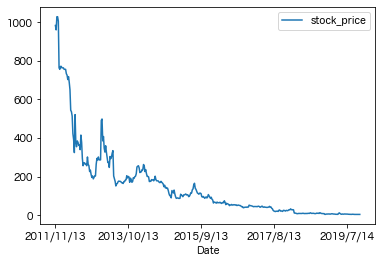

In [17]:
df[df["Symbol"] == "ABIO"].plot(x="Date", y="stock_price")

<AxesSubplot:xlabel='Date'>

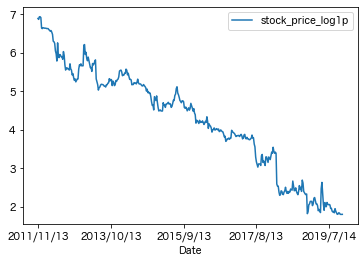

In [9]:
df[df["Symbol"] == "ABIO"].plot(x="Date", y="stock_price_log1p")

<AxesSubplot:xlabel='Date'>

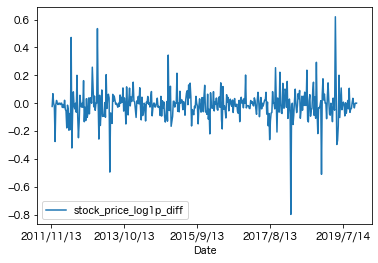

In [10]:
df[df["Symbol"] == "ABIO"].plot(x="Date", y="stock_price_log1p_diff")

<AxesSubplot:xlabel='Date'>

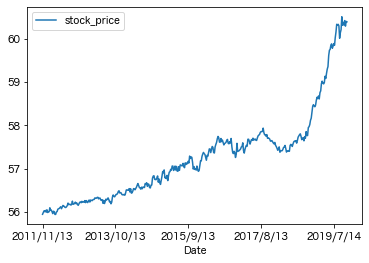

In [11]:
df[df["Symbol"] == "VGSH"].plot(x="Date", y="stock_price")

<AxesSubplot:xlabel='Date'>

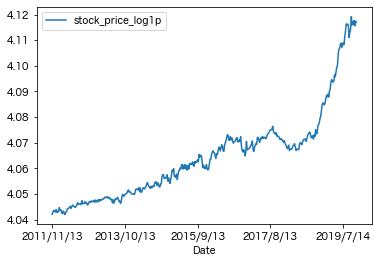

In [12]:
df[df["Symbol"] == "VGSH"].plot(x="Date", y="stock_price_log1p")

<AxesSubplot:xlabel='Date'>

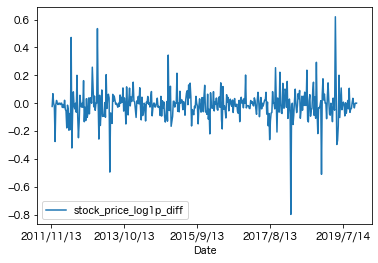

In [13]:
df[df["Symbol"] == "ABIO"].plot(x="Date", y="stock_price_log1p_diff")

<AxesSubplot:xlabel='Date'>

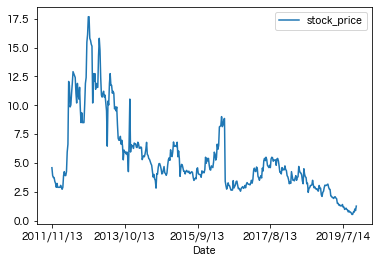

In [21]:
df[df["Symbol"] == "ADMP"].plot(x="Date", y="stock_price")

## companyごとの調査

In [14]:
df.head()

,Date,Symbol,stock_price,stock_price_log1p,stock_price_log1p_exm1,stock_price_log1p_1s,stock_price_log1p_diff,stock_price_1s,stock_price_diff,stock_price_1s_4r,stock_price_diff_ratio
0,2011/11/13,VGSH,55.942184,4.042036,55.942184,NaN,NaN,NaN,NaN,NaN,NaN
1,2011/11/20,VGSH,55.978844,4.042680,55.978844,4.042036,0.000644,55.942184,0.036659,55.942184,0.000655
2,2011/11/27,VGSH,56.021038,4.043420,56.021038,4.042680,0.000740,55.978844,0.042194,55.960514,0.000754
3,2011/12/4,VGSH,56.002697,4.043099,56.002697,4.043420,-0.000322,56.021038,-0.018341,55.980689,-0.000328
4,2011/12/11,VGSH,56.030224,4.043581,56.030224,4.043099,0.000483,56.002697,0.027527,55.986191,0.000492


In [15]:
# 全Symbol同期間のデータがある
df_agg = df.groupby("Symbol", as_index=False)["Date"].agg(["min", "max"])
df_agg.reset_index(drop=True).drop_duplicates()

,min,max
0,2011/11/13,2019/9/8


## 特徴量作成

- category
    - company
        - Sector
        - List
    - ymd(yearは2017年まで学習して2018年を予測すると精度が悪化する可能性があるため使わない)
        - month
        - day
        - week_of_month
        - week_of_year
- float64
    - IOPyear
    - 1週間前
    - 4, 8, 12週間の平均値, 中央値, 標準偏差
    - Sectorの1週間前の平均値, 中央値, 標準偏差
    - Listの1週間前の平均値, 中央値, 標準偏差

In [42]:
# ymd関連
df_ymd = df.copy()
df_ymd["Date_datetime"] = pd.to_datetime(df_ymd["Date"])
df_ymd["year"] = df_ymd["Date_datetime"].dt.year
df_ymd["month"] = df_ymd["Date_datetime"].dt.month
df_ymd["day"] = df_ymd["Date_datetime"].dt.day

def calc_week_no(day):
    """
    週番号を返す関数

    Args:
        day (date):日付（何日目か）
    Returns:
        week_no (int)：週番号
    """
    week_no = (day - 1) // 7 + 1
    return week_no

df_ymd["week_of_month_"] = df_ymd["Date_datetime"].dt.day.map(calc_week_no)  # 週番号（月）
df_ymd["week_of_year"] = df_ymd["Date_datetime"].dt.isocalendar().week  # 週番号(年)

display(df_ymd.head(10))

,Date,Symbol,stock_price,stock_price_log1p,stock_price_log1p_exm1,stock_price_log1p_1s,stock_price_log1p_diff,stock_price_1s,stock_price_diff,stock_price_1s_4r,stock_price_diff_ratio,Date_datetime,year,month,day,week_of_month_,week_of_year
0,2011/11/13,VGSH,55.942184,4.042036,55.942184,NaN,NaN,NaN,NaN,NaN,NaN,2011-11-13,2011,11,13,2,45
1,2011/11/20,VGSH,55.978844,4.042680,55.978844,4.042036,0.000644,55.942184,0.036659,55.942184,0.000655,2011-11-20,2011,11,20,3,46
2,2011/11/27,VGSH,56.021038,4.043420,56.021038,4.042680,0.000740,55.978844,0.042194,55.960514,0.000754,2011-11-27,2011,11,27,4,47
3,2011/12/4,VGSH,56.002697,4.043099,56.002697,4.043420,-0.000322,56.021038,-0.018341,55.980689,-0.000328,2011-12-04,2011,12,4,1,48
4,2011/12/11,VGSH,56.030224,4.043581,56.030224,4.043099,0.000483,56.002697,0.027527,55.986191,0.000492,2011-12-11,2011,12,11,2,49
5,2011/12/18,VGSH,55.991684,4.042905,55.991684,4.043581,-0.000676,56.030224,-0.038540,56.008201,-0.000688,2011-12-18,2011,12,18,3,50
6,2011/12/25,VGSH,56.046795,4.043872,56.046795,4.042905,0.000967,55.991684,0.055111,56.011411,0.000984,2011-12-25,2011,12,25,4,51
7,2012/1/1,VGSH,55.982456,4.042743,55.982456,4.043872,-0.001128,56.046795,-0.064339,56.017850,-0.001149,2012-01-01,2012,1,1,1,52
8,2012/1/8,VGSH,56.000862,4.043066,56.000862,4.042743,0.000323,55.982456,0.018406,56.012790,0.000329,2012-01-08,2012,1,8,2,1
9,2012/1/15,VGSH,56.000862,4.043066,56.000862,4.043066,0.000000,56.000862,0.000000,56.005449,0.000000,2012-01-15,2012,1,15,3,2


In [71]:
df.head(2)

,Date,Symbol,stock_price,IPOyear,Sector,List,stock_price_log1p,stock_price_log1p_1s,stock_price_log1p_diff,stock_price_log1p_diff_1s,stock_price_log1p_diff_2s,stock_price_log1p_diff_1s_4r,stock_price_log1p_diff_1s_8r,stock_price_log1p_diff_1s_12r,stock_price_log1p_diff_1s_4r_med,stock_price_log1p_diff_1s_8r_med,stock_price_log1p_diff_1s_12r_med,stock_price_log1p_diff_1s_4r_std,stock_price_log1p_diff_1s_8r_std,stock_price_log1p_diff_1s_12r_std
0,2011/11/13,VGSH,55.942184,NaN,NaN,NASDAQ,4.042036,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2011/11/20,VGSH,55.978844,NaN,NaN,NASDAQ,4.042680,4.042036,0.000644,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [74]:
def create_ymd_features(input: pd.DataFrame) -> pd.DataFrame:
    """ymd関連の特徴量を作成する関数

    Args:
        input (pd.DataFrame): _description_

    Returns:
        pd.DataFrame: _description_
    """
    df_ymd = input[["Date"]].copy()

    df_ymd["Date_datetime"] = pd.to_datetime(df_ymd["Date"])
    df_ymd["year"] = df_ymd["Date_datetime"].dt.year
    df_ymd["month"] = df_ymd["Date_datetime"].dt.month
    df_ymd["day"] = df_ymd["Date_datetime"].dt.day
    df_ymd["week_of_month_"] = df_ymd["Date_datetime"].dt.day.map(calc_week_no)  # 週番号（月）
    df_ymd["week_of_year"] = df_ymd["Date_datetime"].dt.isocalendar().week  # 週番号(年)
    df_ymd = df_ymd.drop("Date_datetime", axis=1)
    return df_ymd


def calc_week_no(day):
    """
    週番号を返す関数

    Args:
        day (date):日付（何日目か）
    Returns:
        week_no (int)：週番号
    """
    week_no = (day - 1) // 7 + 1
    return week_no

In [75]:
create_ymd_features(df).head()

,Date,year,month,day,week_of_month_,week_of_year
0,2011/11/13,2011,11,13,2,45
1,2011/11/20,2011,11,20,3,46
2,2011/11/27,2011,11,27,4,47
3,2011/12/4,2011,12,4,1,48
4,2011/12/11,2011,12,11,2,49


## train, validation, test期間

※リークするためクロスバリデーションはできない
- train
    - 2011/11/13 ~ 2018/12/30
- validation
    - 2019/1/6 ~ 2019/11/10
- test
    - 2019/11/17